In [49]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

In [50]:
class MNISTSubset:
    def __init__(self, num_samples, num_classes):
        self.num_samples = num_samples
        self.num_classes = num_classes

    def load_data(self):
        # 加载原始 MNIST 数据集
        train_images = idx2numpy.convert_from_file(r"..\train-images.idx3-ubyte")
        train_labels = idx2numpy.convert_from_file(r"..\train-labels.idx1-ubyte")
        test_images = idx2numpy.convert_from_file(r"..\t10k-images.idx3-ubyte")
        test_labels = idx2numpy.convert_from_file(r"..\t10k-labels.idx1-ubyte")

        # 数据预处理
        train_images = train_images.reshape((train_images.shape[0], -1)).astype('float32') / 255
        test_images = test_images.reshape((test_images.shape[0], -1)).astype('float32') / 255

        # 计算原始数据集中训练集和测试集的比例
        total_train = train_images.shape[0]
        total_test = test_images.shape[0]
        train_test_ratio = total_train / total_test

        # 提取所需类别的样本
        train_data, test_data = self.extract_subset(train_images, train_labels, test_images, test_labels, train_test_ratio)

        return train_data, test_data

    def extract_subset(self, train_images, train_labels, test_images, test_labels, train_test_ratio):
        # 计算训练集和测试集的样本数量
        total_samples = self.num_samples
        train_samples = int(total_samples * train_test_ratio / (1 + train_test_ratio))
        test_samples = total_samples - train_samples

        # 按类别从训练集和测试集中随机抽取样本
        train_subset_indices = []
        test_subset_indices = []

        for i in range(self.num_classes):
            train_indices_i = np.where(train_labels == i)[0]
            test_indices_i = np.where(test_labels == i)[0]

            train_subset_indices_i = np.random.choice(train_indices_i, min(len(train_indices_i), train_samples // self.num_classes), replace=False)
            test_subset_indices_i = np.random.choice(test_indices_i, min(len(test_indices_i), test_samples // self.num_classes), replace=False)

            train_subset_indices.extend(train_subset_indices_i)
            test_subset_indices.extend(test_subset_indices_i)

        # 提取子集
        train_images_subset = train_images[train_subset_indices]
        train_labels_subset = train_labels[train_subset_indices]
        test_images_subset = test_images[test_subset_indices]
        test_labels_subset = test_labels[test_subset_indices]

        # one-hot 编码
        train_labels_subset = self.one_hot_encode(train_labels_subset)
        test_labels_subset = self.one_hot_encode(test_labels_subset)

        return (train_images_subset, train_labels_subset), (test_images_subset, test_labels_subset)

    def one_hot_encode(self, labels):
        # 将类别标签转换为 one-hot 编码格式
        one_hot_labels = np.zeros((labels.shape[0], self.num_classes))
        one_hot_labels[np.arange(labels.shape[0]), labels] = 1
        return one_hot_labels

num_classes = 8
mnist_subset = MNISTSubset(60000, num_classes)  # 总共 3000 个样本, 8 个类别
train_data, test_data = mnist_subset.load_data()


train_images, train_labels = train_data
test_images, test_labels = test_data

print(f'训练数据集维度：{train_images.shape}')
print(f'训练标签集维度：{train_labels.shape}')

训练数据集维度：(47886, 784)
训练标签集维度：(47886, 8)


In [51]:

class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # 初始化Adam优化器的参数
        self.learning_rate = learning_rate  # 设置学习率
        self.beta1 = beta1  # 设置一阶矩估计（momentum）的衰减率
        self.beta2 = beta2  # 设置二阶矩估计（RMSprop）的衰减率
        self.epsilon = epsilon  # 防止除以零的小常数
        self.t = 0  # 初始化时间步，用于偏差校正

    def update_parameters(self, nn, gradients_w, gradients_b):
        # 更新神经网络的参数
        if not hasattr(self, 'm_w'):
            # 如果moment向量还没有初始化，则进行初始化
            self.m_w = [np.zeros_like(w) for w in nn.weights]  # 初始化权重的一阶矩估计
            self.v_w = [np.zeros_like(w) for w in nn.weights]  # 初始化权重的二阶矩估计
            self.m_b = [np.zeros_like(b) for b in nn.biases]   # 初始化偏置的一阶矩估计
            self.v_b = [np.zeros_like(b) for b in nn.biases]   # 初始化偏置的二阶矩估计

        self.t += 1  # 增加时间步
        correction1 = 1 - self.beta1 ** self.t  # 计算一阶矩估计的偏差校正因子
        correction2 = 1 - self.beta2 ** self.t  # 计算二阶矩估计的偏差校正因子

        for i in range(len(nn.weights)):
            # 遍历神经网络的每一层
            self.m_w[i] *= self.beta1  # 对权重的一阶矩估计应用指数衰减
            self.m_w[i] += (1 - self.beta1) * gradients_w[i]  # 更新权重的一阶矩估计
            self.v_w[i] *= self.beta2  # 对权重的二阶矩估计应用指数衰减
            self.v_w[i] += (1 - self.beta2) * np.square(gradients_w[i])  # 更新权重的二阶矩估计

            m_w_corrected = self.m_w[i] / correction1  # 应用偏差校正到权重的一阶矩估计
            v_w_corrected = self.v_w[i] / correction2  # 应用偏差校正到权重的二阶矩估计

            nn.weights[i] -= self.learning_rate * m_w_corrected / (np.sqrt(v_w_corrected) + self.epsilon)  # 更新权重

            self.m_b[i] *= self.beta1  # 对偏置的一阶矩估计应用指数衰减
            self.m_b[i] += (1 - self.beta1) * gradients_b[i]  # 更新偏置的一阶矩估计
            self.v_b[i] *= self.beta2  # 对偏置的二阶矩估计应用指数衰减
            self.v_b[i] += (1 - self.beta2) * np.square(gradients_b[i])  # 更新偏置的二阶矩估计

            m_b_corrected = self.m_b[i] / correction1  # 应用偏差校正到偏置的一阶矩估计
            v_b_corrected = self.v_b[i] / correction2  # 应用偏差校正到偏置的二阶矩估计

            nn.biases[i] -= self.learning_rate * m_b_corrected / (np.sqrt(v_b_corrected) + self.epsilon)  # 更新偏置

        return nn.weights, nn.biases


In [52]:
class SimpleNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate):
        # 神经网络的构造函数
        # np.random.seed(i+20)  # 设置随机种子以确保结果的可重复性
        # 初始化网络的权重，使用标准正态分布随机生成
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)]
        # 初始化网络的偏置，全部设置为零
        self.biases = [np.zeros((1, layer_sizes[i + 1])) for i in range(len(layer_sizes) - 1)]
        # 创建一个 Adam 优化器实例用于训练
        self.optimizer = AdamOptimizer(learning_rate=learning_rate)

    @staticmethod
    def sigmoid(x):
        # Sigmoid 激活函数
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        # Sigmoid 函数的导数
        return x * (1 - x)
    
    @staticmethod
    def softmax(x):
        # Softmax 函数，用于多分类问题的输出层
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止数值溢出
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def fp(self, input):
        # 神经网络的前向传播
        activations = [input]  # 存储每层的激活值
        # 遍历除最后一层外的每一层
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            # 计算下一层的激活值
            activations.append(SimpleNeuralNetwork.sigmoid(np.dot(activations[-1], w) + b))
        # 计算最后一层的激活值，使用 softmax
        activations.append(SimpleNeuralNetwork.softmax(np.dot(activations[-1], self.weights[-1]) + self.biases[-1]))
        return activations  # 返回所有层的激活值

    

    def bp(self, x, y, sam_weight):
        # 神经网络的反向传播
        activations = self.fp(x)  # 获取前向传播的结果
        dL_dy =  sam_weight[:, np.newaxis] * (activations[-1] - y)  # 计算输出层的误差的偏导数
        gradients_w = []  # 存储权重的梯度
        gradients_b = []  # 存储偏置的梯度

        # 从输出层到输入层反向遍历每一层
        for i in range(len(self.weights) - 1, -1, -1):
            # 计算激活值对加权输入的偏导数
            da_dz = self.sigmoid_derivative(activations[i+1])
            # 应用链式法则更新偏导数
            if i != len(self.weights) - 1:
                dL_dz = dL_dy * da_dz
            else:
                dL_dz = dL_dy  # 对于输出层，偏导数就是dL_dy
            grad_w = activations[i].T.dot(dL_dz)  # 计算权重的梯度
            grad_b = np.sum(dL_dz, axis=0, keepdims=True)  # 计算偏置的梯度
            gradients_w.append(grad_w)  # 添加权重梯度
            gradients_b.append(grad_b)  # 添加偏置梯度
            # 更新偏导数传播到前一层
            if i != 0:
                dL_dy = dL_dz.dot(self.weights[i].T)

        gradients_w.reverse()  # 反转梯度列表
        gradients_b.reverse()  # 反转梯度列表

        return gradients_w, gradients_b 


    def train(self, x, y, sample_weight, epochs):
        # 训练神经网络
        for epoch in range(epochs): # 训练轮数
            gradients_w, gradients_b = self.bp(x, y, sample_weight) # 反向传播，计算各个权重与偏置的梯度
            self.optimizer.update_parameters(self, gradients_w, gradients_b) # 更新参数
        
        return self.weights, self.biases  # 返回训练后的权重、偏置

    def cross_entropy_loss(self, y_pred, y_true):
        # 交叉熵损失函数
        m = y_true.shape[0]  # 获取样本数量
        loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / m  # 计算交叉熵损失
        return loss

    def predict(self, input):
        # 预测函数
        return self.fp(input)[-1]  # 返回最后一层的激活值，即预测结果

    def evaluate_accuracy(self, x, y):
        # 评估模型准确率
        predictions = self.predict(x)  # 获取预测结果
        predicted_classes = np.argmax(predictions, axis=1)  # 获取预测的类别
        true_classes = np.argmax(y, axis=1)  # 获取真实的类别
        return np.mean(predicted_classes == true_classes)  # 计算准确率
    


In [53]:
# 显示总样本数，训练集和测试集的大小
total_samples = train_images.shape[0] + test_images.shape[0]
train_size = train_images.shape[0]
test_size = test_images.shape[0]

print(f"总样本数: {total_samples}", f"训练集大小: {train_size}", f"测试集大小: {test_size}")


learning_rate = 0.05
batch_size = 32


print(f"学习率: {learning_rate}, batch_size: {batch_size}")
# 创建神经网络实例
layer_sizes = [784, 15, num_classes]

# 显示隐藏层的层数以及每层神经元的个数
num_hidden_layers = len(layer_sizes) - 2  # 输入层和输出层之外的层数
print(f"隐藏层的层数: {num_hidden_layers}")
for i, size in enumerate(layer_sizes[1:-1], start=1):
    print(f"隐藏层 {i} 的神经元个数: {size}")

总样本数: 55839 训练集大小: 47886 测试集大小: 7953
学习率: 0.05, batch_size: 32
隐藏层的层数: 1
隐藏层 1 的神经元个数: 15


NN准确率：0.8505
增加1个分类器后Adaboost的准确率：0.8505
NN准确率：0.7900
增加2个分类器后Adaboost的准确率：0.8790
NN准确率：0.3713
增加3个分类器后Adaboost的准确率：0.8819
NN准确率：0.1777
增加4个分类器后Adaboost的准确率：0.8822
NN准确率：0.4521
增加5个分类器后Adaboost的准确率：0.8879
NN准确率：0.5982
增加6个分类器后Adaboost的准确率：0.8997
NN准确率：0.3165
增加7个分类器后Adaboost的准确率：0.9009
NN准确率：0.3929
增加8个分类器后Adaboost的准确率：0.9021
NN准确率：0.4218
增加9个分类器后Adaboost的准确率：0.9046
NN准确率：0.4916
增加10个分类器后Adaboost的准确率：0.9099
NN准确率：0.4120
增加11个分类器后Adaboost的准确率：0.9130
NN准确率：0.5661
增加12个分类器后Adaboost的准确率：0.9172
NN准确率：0.4461
增加13个分类器后Adaboost的准确率：0.9195
NN准确率：0.5142
增加14个分类器后Adaboost的准确率：0.9233
NN准确率：0.4051
增加15个分类器后Adaboost的准确率：0.9248
NN准确率：0.4045
增加16个分类器后Adaboost的准确率：0.9261
NN准确率：0.5513
增加17个分类器后Adaboost的准确率：0.9286
NN准确率：0.2210
增加18个分类器后Adaboost的准确率：0.9286
NN准确率：0.3346
增加19个分类器后Adaboost的准确率：0.9302
NN准确率：0.2677
增加20个分类器后Adaboost的准确率：0.9305
NN准确率：0.4968
增加21个分类器后Adaboost的准确率：0.9330
NN准确率：0.1583
增加22个分类器后Adaboost的准确率：0.9330
NN准确率：0.2403
增加23个分类器后Adaboost的准确率：0.9336
NN准确率：0.3096
增加24个分类器后Adaboost的准确率：0.9343
N

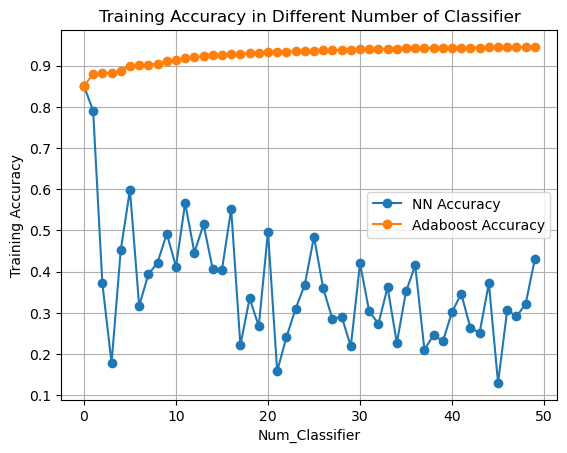

In [54]:
# 定义训练数据集中样本的总数
num_samples = len(train_images)

# 初始化样本权重为None，后面会根据需要进行初始化
weights = None 

# 设置要训练的分类器数量
num_classifiers = 50

# 初始化用于存储训练过程中的预测结果的数组，其形状与训练标签相同
pre_train_boost = np.zeros_like(train_labels)

# 初始化存储每个分类器的alpha值的列表，alpha是用来衡量分类器重要性的指标
alphas = [] 

# 初始化存储每个分类器训练准确率的列表
train_acc_list = []

# 初始化存储所有训练过的神经网络的列表
networks = []

# 初始化存储Adaboost算法每一步的准确率的列表
boost_acc_list = []

# 遍历每个分类器，进行训练和评估
for i in range(num_classifiers):
    # 创建并训练神经网络。SimpleNeuralNetwork是一个神经网络类，需要传入网络结构和学习率
    nn = SimpleNeuralNetwork(layer_sizes, learning_rate=learning_rate)
    # 如果权重尚未初始化，则进行均匀初始化
    if weights is None:
        weights = np.ones(num_samples) / num_samples
    # 使用训练数据、标签和权重来训练神经网络，训练20轮
    nn.train(train_images, train_labels, weights, 20)
    # 将训练好的网络加入到网络列表中
    networks.append(nn)

    # 计算当前神经网络在训练集上的准确率，并打印
    train_acc = nn.evaluate_accuracy(train_images, train_labels)
    train_acc_list.append(train_acc)
    print(f'NN准确率：{train_acc:.4f}')

    # 基于神经网络的预测和真实标签来计算分类错误率
    prediction_class = np.argmax(nn.predict(train_images), axis=1)
    real_class = np.argmax(train_labels, axis=1)
    error = np.count_nonzero(prediction_class != real_class) / num_samples
    # 设置一个非常小的数epsilon，避免在计算alpha时分母为零
    epsilon = 1e-10
    # 根据错误率计算alpha值，alpha值越大表示分类器越重要
    alpha = 0.5 * np.log(((2 - 2/num_classes) - error + epsilon) / (error + epsilon))
    alphas.append(alpha)

    # 更新训练样本的权重，对于分类正确的样本降低其权重，分类错误的样本增加其权重
    for j in range(num_samples):
        if prediction_class[j] == real_class[j]:
            weights[j] = weights[j] * np.exp(-alpha)
        else:
            weights[j] = weights[j] * np.exp(alpha)
    # 保证所有权重之和为1
    weights = weights / np.sum(weights)

    # 计算并更新Adaboost模型的预测结果，每个分类器的贡献由其alpha值决定
    pre_train_boost += alphas[i] * nn.predict(train_images)
    # 计算并打印当前Adaboost模型在训练集上的准确率
    boost_acc = np.mean(np.argmax(pre_train_boost, axis=1) == np.argmax(train_labels, axis=1))
    print(f'增加{i+1}个分类器后Adaboost的准确率：{boost_acc:.4f}')
    # 将当前准确率添加到Adaboost准确率列表中
    boost_acc_list.append(boost_acc)

print('--------------------------------')
print(f'弱分类器中最大准确率: {np.max(train_acc_list):.4f}, 平均准确率：{np.mean(train_acc_list):.4f}')
print(f'Adaboost最大准确率: {np.max(boost_acc_list):.4f}, 平均准确率：{np.mean(boost_acc_list):.4f}')

alphas = [round(alpha, 2) for alpha in alphas]
print(f'各分类器权重{alphas}')

plt.plot(range(len(train_acc_list)), train_acc_list, marker='o', label='NN Accuracy')
plt.plot(range(len(boost_acc_list)), boost_acc_list, marker='o', label='Adaboost Accuracy')
plt.legend()
plt.xlabel('Num_Classifier')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy in Different Number of Classifier')
plt.grid(True)
plt.show()